First, let's import everything we need, and load some cetane number data:

In [1]:
# Import the Graph Operator - handles data preparation, model creation/recall, hand-off of data to model
from graphchem import GraphOperator

In [2]:
# Other dependencies are for data segmentation, set metric calculations, plotting
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score
from matplotlib import pyplot as plt

In [3]:
# Load some cetane number data
from graphchem.datasets import load_cn
smiles, cn = load_cn()
print(smiles[:3], '\n', cn[:3])

['CC1=CC=C(O1)C(C2=CC=CO2)C3=CC=C(O3)C', 'CCCCC1=CC=CO1', 'C1CCOCC1'] 
 [[25.5], [13.1], [38.2]]


In [4]:
# Create training, testing subsets
X_train, X_test, y_train, y_test = train_test_split(
    smiles, cn, test_size=0.20, random_state=42
)
print(len(X_train), len(y_train), len(X_test), len(y_test))

368 368 92 92


We need to set up some variables for our training process (i.e. hyper-parameters). In the future, these will be tunable to reduce model error.

In [5]:
training_config = {
    'task': 'graph',
    'valid_size': 0.2,
    'valid_epoch_iter': 1,
    'valid_patience': 48,
    'batch_size': 32,
    'learning_rate': 0.002,
    'lr_decay': 0.0000001,
    'epochs': 500,
    'verbose': 1
}

We also need to define our model's architecture:

In [6]:
model_config = {
    'n_messages': 2,
    'n_hidden': 3,
    'hidden_msg_dim': 128,
    'hidden_dim': 256,
    'dropout': 0.01
}

Now let's initialize the Graph Operator, and train our model:

In [7]:
go = GraphOperator(config=training_config)
go.train(X_train, y_train, model_config=model_config)

/Users/tjkessler/anaconda3/envs/torch_geometric/lib/python3.8/site-packages/graphchem-1.0.0-py3.8.egg/graphchem/operator.py:43: UserWarning: device config value not found: default value set, cpu
  warnings.warn(


Epoch: 0 | Train Loss: 3773.1604695222813 | Valid Loss: 883.2693481445312
Epoch: 1 | Train Loss: 604.8151932281702 | Valid Loss: 466.1271057128906
Epoch: 2 | Train Loss: 358.2356429846108 | Valid Loss: 425.5957336425781
Epoch: 3 | Train Loss: 360.35298748405614 | Valid Loss: 363.82763671875
Epoch: 4 | Train Loss: 399.4377628248565 | Valid Loss: 363.82763671875
Epoch: 5 | Train Loss: 330.20345737171823 | Valid Loss: 363.82763671875
Epoch: 6 | Train Loss: 274.7915805115992 | Valid Loss: 347.2899169921875
Epoch: 7 | Train Loss: 275.06204265153326 | Valid Loss: 347.2899169921875
Epoch: 8 | Train Loss: 354.8677006935587 | Valid Loss: 311.00421142578125
Epoch: 9 | Train Loss: 378.0789961003933 | Valid Loss: 311.00421142578125
Epoch: 10 | Train Loss: 307.9520719359521 | Valid Loss: 311.00421142578125
Epoch: 11 | Train Loss: 284.021933834569 | Valid Loss: 311.00421142578125
Epoch: 12 | Train Loss: 261.06994670426764 | Valid Loss: 309.27276611328125
Epoch: 13 | Train Loss: 274.65874870455997 | 

Epoch: 110 | Train Loss: 155.19402531215124 | Valid Loss: 222.2113037109375
Epoch: 111 | Train Loss: 132.323028149248 | Valid Loss: 222.2113037109375


Let's get predictions, then calculate prediction errors for the training and testing subsets:

In [8]:
y_train_pred = go.use(X_train)
y_test_pred = go.use(X_test)

mae_test = median_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

mae_train = median_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print('Test Set: R2 = {}, MAE = {}'.format(r2_test, mae_test))
print('Train Set: R2 = {}, MAE = {}'.format(r2_train, mae_train))

Test Set: R2 = 0.6703377971204935, MAE = 9.869721412658691
Train Set: R2 = 0.7205368925296933, MAE = 8.29267692565918


And let's plot our results:

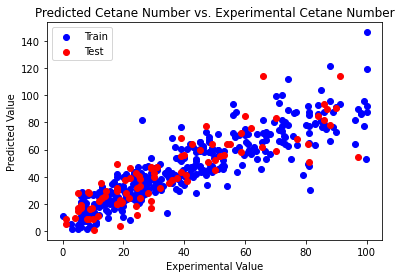

In [9]:
plt.title('Predicted Cetane Number vs. Experimental Cetane Number')
plt.xlabel('Experimental Value')
plt.ylabel('Predicted Value')
plt.scatter(y_train, y_train_pred, color='blue', label='Train')
plt.scatter(y_test, y_test_pred, color='red', label='Test')
plt.legend(loc='upper left')
plt.show()